# 3.4. Linear Regression Implementation from Scratch

We're now ready to work through a fully functioninng implementation of linear regression. In this section, we will implement the entire method from scratch, including (i) the model; (ii) the loss function; (iii) a minibatch stochastic gradient descent optmizer; and (iv) the training function that stitches all of these pieces together. And ultimately we will run our synthetic data generator, and apply our model on the resulting dataset. 

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

## 3.4.1 Defining the Model

Before we can optimize our modele's parameters by minibatch SGD, we need to have some parameters in the first place. In the following code snippet we initialize weights by drawing random numbers from a normal distribution with mean 0 and a standard deviation of 0.01.

The magic number 0.01 often works well in practice, but you can specify a different value thorugh the argument sigma. 

In [2]:
class LinearRegressionScratch(d2l.Module): #@save
    """The Linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

Now we need to define our model, relating its inputs and parameters to its output. Using the mathematical notation from the section 3.1. For our linear model we simply take the matrix-vector product using the input features __X__ and the model weiths __w__, and add the offset _b_ to each example. __Xw__ is a vector and _b_ is a scalar. Due to the braodcasting mechanism, when we add a vector and a sclar, the sclar is added to each component of the vector. 

In [3]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b

## 3.4.2. Defining the Loss Function

Since updating our model requires taking the gradient of our loss function, we ought to define the loss function first. Here we use the squared loss function in (3.1.5). In the implementation, we need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following method will also have the same shape as y_hat. We also return the averaged loss value among all examples in the minibatch


In [4]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

## 3.4.3 Defining the Optmization Algorithm

In [5]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [6]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

## 3.4.4 Training

In [7]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

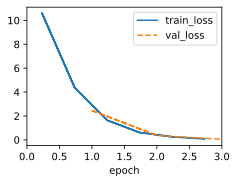

In [8]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [9]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0933, -0.2131], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.2403], grad_fn=<RsubBackward1>)
